<a href="https://colab.research.google.com/github/ICam99/roboticaMovil/blob/main/Tarea4_IgnacioC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install celluloid

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [67]:
# Clase para el vehículo tipo carro
class CarLikeVehicle:
    def __init__(self, L=1.0, max_steering_angle=np.pi/4):
        self.L = L  # Distancia entre ejes
        self.max_steering_angle = max_steering_angle  # Ángulo máximo de dirección

    def kinematic_model(self, state, v, gamma):
        x, y, theta = state
        gamma = np.clip(gamma, -self.max_steering_angle, self.max_steering_angle)

        dx = v * np.cos(theta)
        dy = v * np.sin(theta)
        dtheta = (v / self.L) * np.tan(gamma)

        return np.array([dx, dy, dtheta])

In [68]:
# Controlador para llegar a una posición dada
def go_to_point_controller(state, target, Kv=1.0, Kh=1.0):
    x, y, theta = state
    x_target, y_target = target

    # Error de posición
    distance_error = np.sqrt((x_target - x)**2 + (y_target - y)**2)

    # Velocidad proporcional al error de distancia
    v = Kv * distance_error

    # Ángulo deseado hacia el objetivo
    theta_target = np.arctan2(y_target - y, x_target - x)

    # Error de orientación
    theta_error = theta_target - theta
    theta_error = (theta_error + np.pi) % (2 * np.pi) - np.pi  # Normalizar a [-pi, pi]

    # Ángulo de dirección proporcional al error de orientación
    gamma = Kh * theta_error

    return v, gamma

In [69]:
# Controlador para seguir una línea recta
def follow_line_controller(state, line_params, Kd=1.0, Kh=1.0):
    x, y, theta = state
    a, b, c = line_params

    # Distancia normal a la línea
    denominator = np.sqrt(a**2 + b**2)
    if denominator == 0:
        return 0, 0  # Evitar división por cero
    d = (a * x + b * y + c) / denominator

    # Ángulo deseado paralelo a la línea
    theta_target = np.arctan2(-a, b)

    # Error de orientación
    theta_error = theta_target - theta
    theta_error = (theta_error + np.pi) % (2 * np.pi) - np.pi  # Normalizar a [-pi, pi]

    # Velocidad proporcional a la distancia
    v = Kd * d

    # Ángulo de dirección proporcional al error de orientación
    gamma = Kh * theta_error

    return v, gamma

In [70]:
#Funciones para simular y animar la trayectoria

def simulate(vehicle, controller, initial_state, target, dt=0.1, max_steps=1000):
    state = initial_state
    trajectory = [state]

    for _ in range(max_steps):
        v, gamma = controller(state, target)
        state = state + vehicle.kinematic_model(state, v, gamma) * dt
        trajectory.append(state)

        # Detener si el vehículo está cerca del objetivo
        if np.linalg.norm(state[:2] - target[:2]) < 0.1:
            break

    return np.array(trajectory)

from celluloid import Camera

def animate_trajectory(trajectory, target=None, line_params=None):
    fig, ax = plt.subplots()
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    camera = Camera(fig)

    if target is not None:
        ax.plot(target[0], target[1], 'ro', label='Target')

    if line_params is not None:
        a, b, c = line_params
        x = np.linspace(-10, 10, 100)
        y = (-a * x - c) / b
        ax.plot(x, y, 'g--', label='Line to Follow')

    for i in range(len(trajectory)):
        x = trajectory[:i+1, 0]
        y = trajectory[:i+1, 1]

        ax.plot(x, y, 'b-', label='Trajectory' if i == 0 else "")
        ax.plot(x[-1], y[-1], 'bo')

        camera.snap()

    animation = camera.animate(interval=50)
    plt.legend()

    from IPython.display import HTML
    return HTML(animation.to_html5_video())

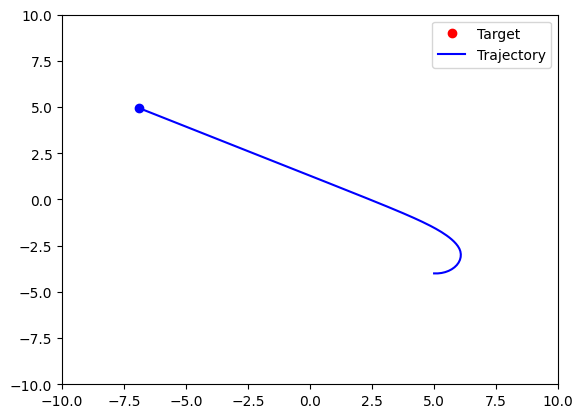

In [71]:
# Parámetros iniciales
initial_state = np.array([5.0, -4.0, 0.0])  # x, y, theta
target = np.array([-7.0, 5.0])  # x, y

# Crear el vehículo
vehicle = CarLikeVehicle()

# Simular la trayectoria
trajectory = simulate(vehicle, go_to_point_controller, initial_state, target, dt=0.05)

# Animar la trayectoria
animate_trajectory(trajectory, target=target)

In [78]:
def animate_line_following(trajectory, line_params):
    fig, ax = plt.subplots()
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    camera = Camera(fig)

    # NO LONGER DRAWING THE LINE OUTSIDE THE LOOP
    # a, b, c = line_params
    # x_line = np.array([-10, 10])
    # y_line = (-a * x_line - c) / b
    # ax.plot(x_line, y_line, 'g--', label='Línea a seguir')


    # Inicializar la trayectoria y el punto
    for i in range(len(trajectory)):
        x = trajectory[:i+1, 0]  # Coordenadas x hasta el frame actual
        y = trajectory[:i+1, 1]  # Coordenadas y hasta el frame actual

        # Redraw the line in each frame
        a, b, c = line_params
        x_line = np.array([-10, 10])
        y_line = (-a * x_line - c) / b
        ax.plot(x_line, y_line, 'g--', label='Línea a seguir' if i==0 else "") # adding the label once will suffice

        ax.plot(x, y, 'b-', label='Trajectory' if i == 0 else "")  # Trayectoria
        ax.plot(x[-1], y[-1], 'bo')  # Punto actual

        camera.snap()  # Capturar el frame

    animation = camera.animate(interval=50)  # Crear la animación
    plt.legend()
    plt.close()

    from IPython.display import HTML
    return HTML(animation.to_html5_video())

# Parámetros iniciales para seguir una línea recta
initial_state = np.array([0.0, 2.5, 0.0])  # x, y, theta
line_params = np.array([1.0, -1.0, 0.0])  # a, b, c (ax + by + c = 0)

# Crear el vehículo
vehicle = CarLikeVehicle()

# Simular la trayectoria para seguir una línea recta
trajectory = simulate(vehicle, follow_line_controller, initial_state, line_params, dt=0.1, max_steps=100)

# Animar la trayectoria para seguir una línea recta
animate_line_following(trajectory, line_params)